In [15]:
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import pandas as pd
import os
import random
import logging

In [38]:
import logging

# Remover todos los handlers existentes
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')



[2025-02-15 14:22:28] INFO: Logging level: INFO


In [42]:
def load_data():
    base_dir = os.path.join("..", "data")
    dataframes = {}
    
    # Recorremos cada directorio en ../data
    for category in os.listdir(base_dir):
        cat_path = os.path.join(base_dir, category)
        if os.path.isdir(cat_path):
            pairs = {}
            # Recorremos cada archivo dentro de la categoría
            for file in os.listdir(cat_path):
                file_path = os.path.join(cat_path, file)
                name, ext = os.path.splitext(file)
                if ext.lower() == ".png":
                    pairs.setdefault(name, {})['img'] = file_path
                elif ext.lower() == ".mat":
                    pairs.setdefault(name, {})['mat'] = file_path
                    
            # Creamos la lista de registros con imagen y puntos
            rows = []
            for base, data in pairs.items():
                if 'img' in data and 'mat' in data:
                    rows.append(data)
                    
            
            df = pd.DataFrame(rows)
            key = f"{category.lower()}_df"
            logger.info(f"Loaded {key} with {len(df)} records")
            dataframes[key] = df
            
    return dataframes
    

In [70]:

def load_single_image_and_points(img_path, mat_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    kpts = np.array(sio.loadmat(mat_path)['pts_coord'])
    return img, kpts

def delaunay_triangulation(kpts):
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def simple_spatial_matching(kpts1, kpts2):
    pts1 = kpts1.T
    pts2 = kpts2.T
    cost_matrix = distance.cdist(pts1, pts2, metric="euclidean")
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    return matching

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1
    composite_img[:h2, w1:w1+w2, :] = img2

    # Trasladar keypoints de la segunda imagen
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1

    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)
    
    # Dibujar grafos de Delaunay para ambas imágenes
    for kpts, adj_matrix, color in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2], ['r', 'b']):
        N = kpts.shape[1]
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], color+'-', linewidth=1)
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)
    
    # Dibujar matching entre keypoints
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide se pinta en verde
        if r == c:
            plt.plot([x1, x2], [y1, y2], 'g-', linewidth=1)
        else:
            plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()

def evaluate_matching_precision(kpts1, matching):
    """
    Se asume que la correspondencia ideal es la diagonal de la matriz de matching.
    """
    N = kpts1.shape[1]
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_categories():
    """
    Para cada categoría:
    1. Selecciona un par aleatorio de imágenes y muestra la visualización.
    2. Recorre imágenes pareadas (por ejemplo, consecutivas) y calcula la precisión para cada par.
    3. Guarda los resultados en un CSV (uno por cada categoría) donde el encabezado tiene
       la media y la desviación, en la forma:
         pair_index,precision media: 0.7384,desviacion: 0.2940
       y debajo se listan los datos de precisión para cada par.
    """
    dataframes = load_data()
    
    for cat_name, df in dataframes.items():
        if len(df) < 2:
            logger.info(f"No hay suficientes imágenes en {cat_name}")
            continue
        
        # Seleccionar de forma aleatoria un par para visualización
        idx1, idx2 = random.sample(range(len(df)), 2)
        row1 = df.iloc[idx1]
        row2 = df.iloc[idx2]
        img1, kpts1 = load_single_image_and_points(row1['img'], row1['mat'])
        img2, kpts2 = load_single_image_and_points(row2['img'], row2['mat'])
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)
        matching = simple_spatial_matching(kpts1, kpts2)
        logger.info(f"Visualizando par aleatorio para {cat_name}")
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)
        
        # Calcular la precisión para pares consecutivos
        precisions = []
        pair_indices = []
        for i in range(len(df)-1):
            row_a = df.iloc[i]
            row_b = df.iloc[i+1]
            img_a, kpts_a = load_single_image_and_points(row_a['img'], row_a['mat'])
            img_b, kpts_b = load_single_image_and_points(row_b['img'], row_b['mat'])
            matching_pair = simple_spatial_matching(kpts_a, kpts_b)
            prec = evaluate_matching_precision(kpts_a, matching_pair)
            precisions.append(prec)
            pair_indices.append(i)
        
        # Calcular estadísticas agregadas
        media = np.mean(precisions)
        std = np.std(precisions)

        # Crear DataFrame de resultados para la categoría (datos de cada par)
        results_df = pd.DataFrame({
            "pair_index": pair_indices,
            "precision": precisions
        })
        
        csv_file = f"{cat_name}_results.csv"
        # Abrir el archivo con newline="" para evitar dobles saltos de línea
        with open(csv_file, "w", newline="") as f:
            header = f"pair_index,precision media: {media:.4f} desviacion: {std:.4f}\n"
            f.write(header)
            # Especificar el separador de línea para que se use solo un '\n'
            results_df.to_csv(f, index=False, header=False)

        logger.info(f"Categoría {cat_name.capitalize()}: Precisión media = {media:.4f}, Desviación = {std:.4f}")
        logger.info(f"Resultados guardados en {csv_file}")


[2025-02-15 15:13:51] INFO: Loaded car_df with 40 records
[2025-02-15 15:13:51] INFO: Loaded duck_df with 50 records
[2025-02-15 15:13:51] INFO: Loaded face_df with 109 records
[2025-02-15 15:13:51] INFO: Loaded motorbike_df with 40 records
[2025-02-15 15:13:51] INFO: Loaded winebottle_df with 66 records
[2025-02-15 15:13:51] INFO: Visualizando par aleatorio para car_df


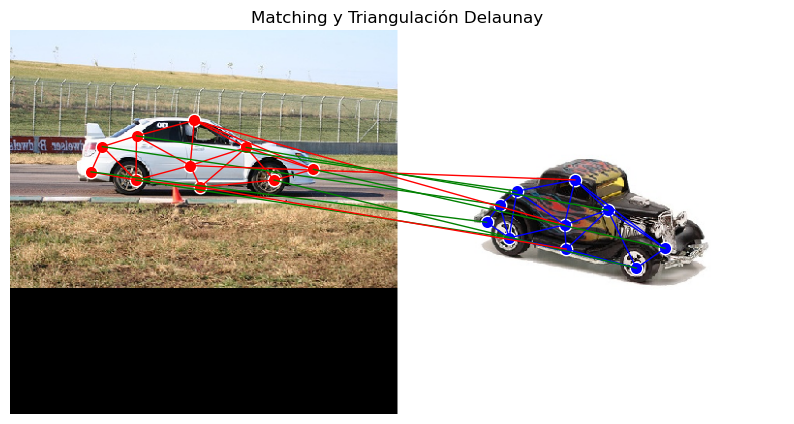

[2025-02-15 15:13:51] INFO: Categoría Car_df: Precisión media = 0.7385, Desviación = 0.2941
[2025-02-15 15:13:51] INFO: Resultados guardados en car_df_results.csv
[2025-02-15 15:13:51] INFO: Visualizando par aleatorio para duck_df


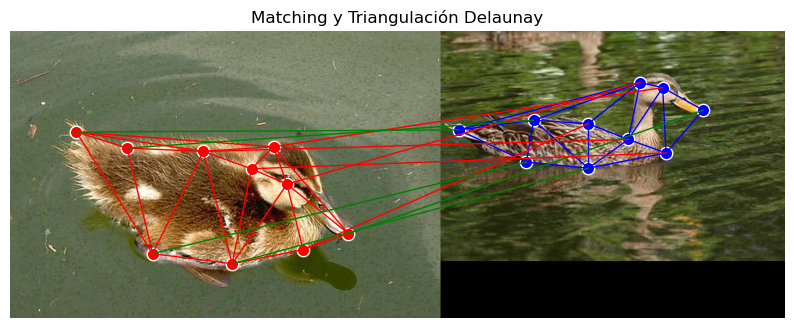

[2025-02-15 15:13:52] INFO: Categoría Duck_df: Precisión media = 0.6735, Desviación = 0.2578
[2025-02-15 15:13:52] INFO: Resultados guardados en duck_df_results.csv
[2025-02-15 15:13:52] INFO: Visualizando par aleatorio para face_df


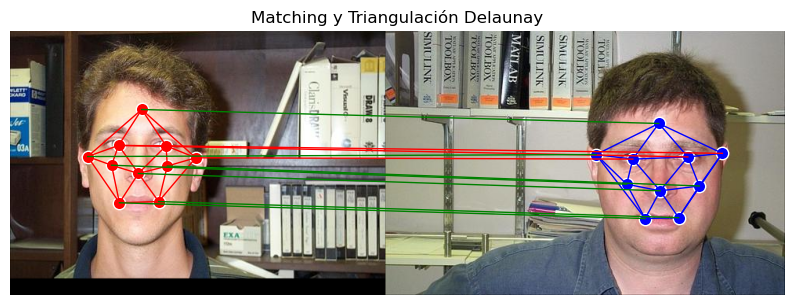

[2025-02-15 15:13:53] INFO: Categoría Face_df: Precisión media = 0.8947, Desviación = 0.1656
[2025-02-15 15:13:53] INFO: Resultados guardados en face_df_results.csv
[2025-02-15 15:13:53] INFO: Visualizando par aleatorio para motorbike_df


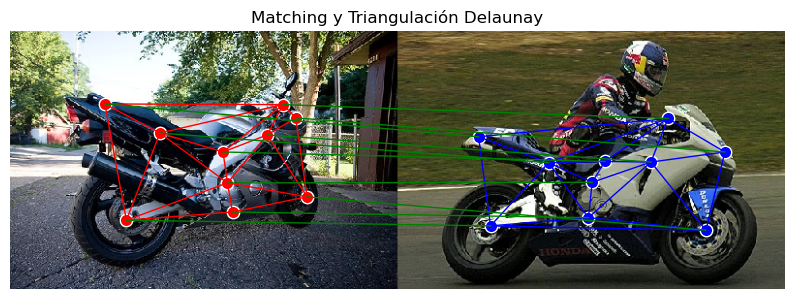

[2025-02-15 15:13:54] INFO: Categoría Motorbike_df: Precisión media = 0.8974, Desviación = 0.1387
[2025-02-15 15:13:54] INFO: Resultados guardados en motorbike_df_results.csv
[2025-02-15 15:13:54] INFO: Visualizando par aleatorio para winebottle_df


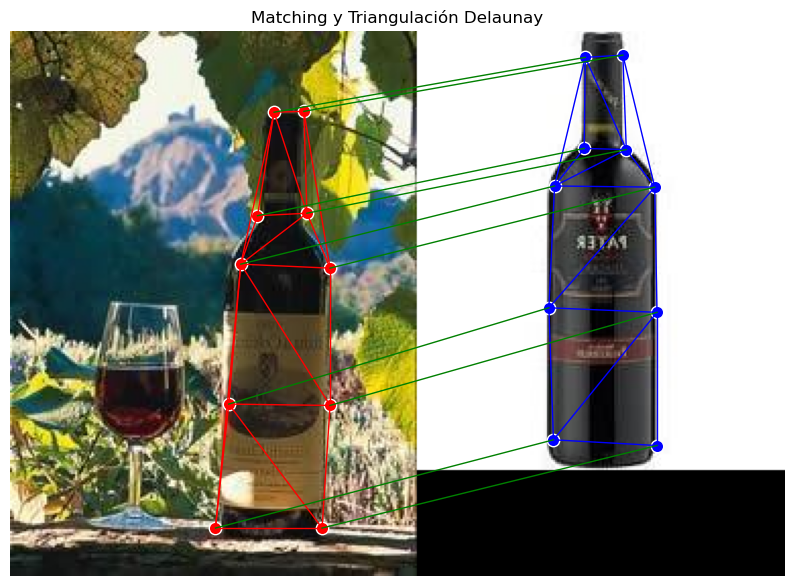

[2025-02-15 15:13:54] INFO: Categoría Winebottle_df: Precisión media = 0.8800, Desviación = 0.1808
[2025-02-15 15:13:54] INFO: Resultados guardados en winebottle_df_results.csv


In [71]:
if __name__ == "__main__":
    
    compute_precision_for_categories()

Configure Test Framework
Confirm your Python testing framework to enable test discovery.